# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

**1. Training Phase (The CNN learns "Pixels")**
Input: The 7-day Data Cube (Weather + Terrain).

Model: The 3D CNN processes this.

Output: It predicts a Danger Map (e.g., a 180x370 grid where every pixel has a value like 2.3 or 3.1).

Loss Function: The model compares its pixel predictions against your Target Raster (from Script 3) to learn.

Note: You do NOT need aggregation here. The model learns best by trying to get every single pixel right.

**2. Inference Phase (The "Aggregation" Step)**
When: This happens when you want to evaluate your model on the Test Set or generate a final forecast.

Input: The Danger Map produced by the CNN.

Action: You run the aggregate_predictions script.

It overlays the SLF Region Mask.

It calculates the 90th percentile for "Region 15".

Output: A final dictionary: {'Region_15': 3, 'Region_16': 2, ...}.

**3. Comparison Phase (The Final Grade)**
You take that final dictionary (Regional Forecast).

You compare it against the Original CSV Ground Truth (not the raster).

This gives you your final Macro-F1 Score to compare against the Random Forest.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

## **5. CNN Model**

In [2]:
DYNAMIC_FEATURES = [
    # --- 1. The "Super Predictors" (Top Correlations) ---
    'delta_elevation',    # Rank #2 (r=-0.601). Critical context.
    'Pen_depth',          # Rank #3 (r=+0.581). Best proxy for "unstable new snow".
    'HN72_24',            # Rank #4 (r=+0.543). Best measure of cumulative loading.

    # --- 2. The "Driver" Group (Weather) ---
    'TA',                 # Rank #7 (r=-0.420). Temperature is the main "state" variable.
    'wind_trans24',       # Rank #8-ish. Captures the "loading" effect better than raw wind.
    'RH',                 # Rank #13 (r=+0.360). Proxy for storm presence.

    # --- 3. The "Stability" Group (Snowpack Structure) ---
    # We chose min_ccl_pen over Sn because your EDA showed it has higher correlation
    # (r=-0.374 vs r=-0.292).
    'min_ccl_pen',        

    # --- 4. The "Engineered" Context ---
    'relative_load_3d',   # You proved this had strong correlation (+0.410) in feature engineering.
    
    # --- 5. Raw Wind (Required for CNN Spatial Learning) ---
    # Even though raw 'VW' had lower correlation, the CNN NEEDS vectors to learn 
    # "Lee Slope Loading" patterns spatially.
    # Note: The script adds 'wind_u' and 'wind_v' automatically from VW/DW.
    'VW', 'DW' 
]

In [ ]:
# Inputs
GRID_DIR = '../data/grids'
DYNAMIC_DIR = os.path.join(GRID_DIR, 'dynamic')
TARGET_DIR = os.path.join(GRID_DIR, 'targets')
STATIC_FILE = os.path.join(GRID_DIR, 'static_terrain.npy')

# Must match your Script 2 generation order!
FEATURE_NAMES = [
    'delta_elevation', 'Pen_depth', 'HN72_24',  # Top Predictors
    'TA', 'wind_trans24', 'RH',                 # Weather Drivers
    'min_ccl_pen',                              # Stability
    'relative_load_3d',                         # Engineered
    'wind_u', 'wind_v'                          # Vectors
]

# Hyperparameters
BATCH_SIZE = 4        # Small batch size because 3D tensors are huge in RAM
LEARNING_RATE = 1e-4
EPOCHS = 10
LOOKBACK = 7          # T-6 to T
NUM_CLASSES = 5       # 0=NoData (Ignore), 1, 2, 3, 4 (High)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running on device: {DEVICE}")

Running on device: cpu


In [ ]:
class AvalancheDataset(Dataset):
    def __init__(self, date_list, feature_dir, target_dir, static_file, stats, features, lookback=7):
        self.dates = date_list
        self.feature_dir = feature_dir
        self.target_dir = target_dir
        self.stats = stats
        self.features = features
        self.lookback = lookback
        
        # Load static data once (H, W, 4) -> (Elevation, Slope, AspectSin, AspectCos)
        self.static_data = np.load(static_file).astype(np.float32)

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx):
        target_date = pd.to_datetime(self.dates[idx])
        
        # 1. Build Dynamic Sequence (T-6 to T) 
        frames = []
        start_date = target_date - pd.Timedelta(days=self.lookback - 1)
        
        for i in range(self.lookback):
            d_str = (start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
            f_path = os.path.join(self.feature_dir, f"{d_str}.npz")
            
            if os.path.exists(f_path):
                # Load raw data (H, W, C)
                raw = np.load(f_path)['data']
                norm = np.zeros_like(raw)
                # Normalize channel-wise
                for c, name in enumerate(self.features):
                    mu, std = self.stats[name]['mean'], self.stats[name]['std']
                    norm[..., c] = (raw[..., c] - mu) / (std + 1e-6)
                frames.append(norm)
            else:
                # Missing day? Fill with zeros
                frames.append(np.zeros_like(self.static_data[..., :len(self.features)]))
        
        # Stack -> (Time, H, W, C_dyn)
        dynamic_tensor = np.stack(frames, axis=0)

        # --- 2. Add Static Data ---
        # Repeat static data for every timestep
        static_expanded = np.tile(self.static_data[np.newaxis, ...], (self.lookback, 1, 1, 1))
        
        # Combine -> (Time, H, W, Total_Channels)
        full_cube = np.concatenate([dynamic_tensor, static_expanded], axis=-1)

        # --- 3. Load Target ---
        t_path = os.path.join(self.target_dir, f"{self.dates[idx]}.npy")
        if os.path.exists(t_path):
            # Background is -1, Classes are 1,2,3,4.
            # We shift classes to 0,1,2,3,4 for PyTorch? 
            # Actually, simpler: Let's map -1 -> 0 (Ignore), 1->1, etc.
            label = np.load(t_path).astype(np.int64)
            label[label == -1] = 0 # Move "No Data" to class 0
        else:
            label = np.zeros((self.static_data.shape[0], self.static_data.shape[1]), dtype=np.int64)

        # --- 4. Permute for PyTorch ---
        # Input: (Channels, Time, Height, Width)
        X = torch.from_numpy(full_cube).permute(3, 0, 1, 2)
        Y = torch.from_numpy(label)
        
        return X, Y

In [ ]:
class AvalancheNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AvalancheNet, self).__init__()
        
        # 3D Convolutions: Process (Time, Height, Width)
        # padding='same' keeps the output map size equal to input size
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        
        # Collapse Time Dimension: Average over the 7 days
        # Output becomes (Batch, 64, H, W)
        self.pool_time = nn.AdaptiveAvgPool3d((1, None, None))
        
        # Final 2D Convolutions to map to classes
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # x shape: (Batch, C, T, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        
        # Aggregate Time: (Batch, 64, 1, H, W) -> Squeeze -> (Batch, 64, H, W)
        x = self.pool_time(x).squeeze(2)
        
        # Predict Classes
        x = self.final_conv(x) # (Batch, Num_Classes, H, W)
        return x

Now, from the EDA we know that we are dealing with a highly imbalanced dataset. To tackle this, we will implement a weighted cross-entropy loss function that assigns higher weights to the minority classes. This approach will help the model pay more attention to underrepresented classes during training. We create training and test sets and use ADAM optimizer for training the CNN model.

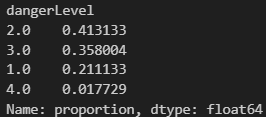

In [ ]:
# 1. Load dates and calculate stats (fast)
df_meta = pd.read_parquet('../data/cleaned_data.parquet')
train_dates = df_meta[df_meta['set'] == 'train']['datum'].unique().astype(str)
val_dates = df_meta[df_meta['set'] == 'test']['datum'].unique().astype(str)
freq_dangerLevel = df_meta['danger_level'].value_counts(normalize=True)
print("Class Distribution in Training Data: {freq_dangerLevel}")

# Calculate stats
stats = {col: {'mean': df_meta[col].mean(), 'std': df_meta[col].std()} for col in FEATURE_NAMES}

# 2. Instantiate Datasets
train_ds = AvalancheDataset(train_dates, DYNAMIC_DIR, TARGET_DIR, STATIC_FILE, stats, FEATURE_NAMES)
val_ds = AvalancheDataset(val_dates, DYNAMIC_DIR, TARGET_DIR, STATIC_FILE, stats, FEATURE_NAMES)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# 3. Initialize Model
# Input channels = 11 dynamic + 4 static = 15
model = AvalancheNet(in_channels=len(FEATURE_NAMES)+4, num_classes=5).to(DEVICE)

# 4. Loss Function with Class Weights
class_counts = torch.tensor([
    0.0,      # Class 0 (NoData) - will be ignored anyway
    0.211133, # Class 1
    0.413133, # Class 2
    0.358004, # Class 3
    0.017729  # Class 4 
], dtype=torch.float32)

# Inverse frequency weighting: weight = 1 / frequency
# For class 0, set weight to 0 since we ignore it
class_weights = torch.zeros(5, dtype=torch.float32)
class_weights[1:] = 1.0 / class_counts[1:]  # Only weight classes 1-4
class_weights = class_weights / class_weights[1:].sum()  # Normalize

print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE), ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

NameError: name 'pd' is not defined

In [ ]:
print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for X, Y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(X)  # Output: (Batch, 5, H, W)
        
        loss = criterion(outputs, Y) # Y is (Batch, H, W)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")
    
    # Optional: Add Validation Loop here
    # Save Checkpoint
    torch.save(model.state_dict(), f"models/cnn_epoch_{epoch+1}.pth")

In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU device count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU detected! Running on CPU.")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device count: 1
GPU name: NVIDIA GeForce RTX 5050 Laptop GPU
GPU memory: 8.55 GB


c:\Users\fabio\miniconda3\envs\avalanche_project\Lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5050 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5050 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0.dev20250310+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 5050 Laptop GPU


c:\Users\fabio\miniconda3\envs\avalanche_project\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5050 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5050 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(
